# Grid-measure plots

In [1]:
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from matplotlib.patches import Rectangle, Arrow, Circle
from analysisutils import short_predictor_names

from prep_data import \
    mazes,\
    model_preds,\
    get_exp1_at,\
    get_exp2_at,\
    get_exp3_at__exp3_mt,\
    get_exp4a_ht,\
    get_exp4b_ht

In [2]:
def clear_axis(
    ax,
    tile_array,
    grid_lineweight=1.25,
    ax_pad=.25/4
):
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    
    for side in ['top','right','bottom','left']:
        ax.spines[side].set_visible(False)
    ax.tick_params(axis='both',which='both',labelbottom=False,bottom=False, left=False, labelleft=False)
    ax.set_xlim(-ax_pad, grid_w+ax_pad)
    ax.set_ylim(-ax_pad, grid_h+ax_pad)
    ax.set_aspect('equal')
    square = Rectangle(
        (0, 0),
        grid_w, grid_h,
        color='w',
        ec='k', 
        lw=grid_lineweight
    )
    ax.add_patch(square)
    
def plot_grid_obstacle_values(
    tile_array,
    ax,
    feature_colors,
    obstacle_values,
    value_range,
    value_format,
    ax_pad=.25/4,
    grid_lineweight=.25,
    invert_color=False
):
    mediumblue = np.array(to_rgb('mediumblue'))
    gainsboro = np.array(to_rgb('gainsboro'))

    def color_mix(v):
        w = v
        return (1-w)*gainsboro + w*mediumblue
    
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    obstacle_locs = {o: [] for o in obstacle_values}
    for x, y in product(range(grid_w), range(grid_h)):
        loc_feature = tile_array[grid_h - y - 1][x]
        if loc_feature in "0123456789":
            obs_value = obstacle_values[loc_feature]
            norm_value = (obs_value - value_range[0])/(value_range[1] - value_range[0])
            if invert_color:
                norm_value = 1 - norm_value
            loc_color = color_mix(norm_value)
            obstacle_locs[loc_feature].append((x, y))
        elif loc_feature in feature_colors:
            loc_color = feature_colors[loc_feature]
        else:
            loc_color = 'white'
        square = Rectangle(
            (x, y),
            1, 1,
            color=loc_color,
            ec='grey', 
            lw=grid_lineweight
        )
        ax.add_patch(square)
        
        if loc_feature == "S":
            ax.plot(
                x + .5, y + .5,
                markeredgecolor='blue',
                marker='o',
                markersize=2.5,
                markeredgewidth=.5,
                fillstyle='none'
            )
        elif loc_feature == "G":
            goal = Rectangle(
                (x + .25, y + .25),
                .5, .5,
                color='green',
                lw=0
            )
            ax.add_patch(goal)
    
    for obstacle, locs in obstacle_locs.items():
        label_loc = calc_obstacle_label_loc(locs, tile_array)
        text = ax.text(
            label_loc[0],
            label_loc[1],
            value_format(obstacle_values[obstacle]),
            color='k',
            ha='center',
            va='center_baseline',
            bbox=dict(facecolor='lightcyan', edgecolor='teal', linewidth=.5, boxstyle='round,pad=.2'),
            fontdict=dict(font="Arial"),
        )
        text.set_fontsize(5)

def calc_obstacle_label_loc(locs, tile_array):
    grid_h, grid_w = len(tile_array), len(tile_array[0])
    locs = np.array(locs) + .5
    mean_loc = np.mean(locs, axis=0)
    obs_bbox_center = np.mean([
        [locs[:,0].min(), locs[:, 1].min()],
        [locs[:,0].max(), locs[:, 1].max()]
    ], axis=0)
    agg_loc = mean_loc*.6 + obs_bbox_center*.4
    agg_loc = (
        min(max(1, agg_loc[0]), grid_w - 1),
        min(max(1, agg_loc[1]), grid_h - 1)
    )
    return agg_loc
    
def value_format(val):
    if val == 0:
        return "0.0"
    elif 0 < val < 1:
        ret =  f"{val:.2f}".lstrip("0")
        if ret == ".00":
            return "0.0"
        elif ret == "1.00":
            return "1.0"
        else:
            return ret
    elif val >= 1:
        return f"{val:.1f}"
    else:
        raise


def create_grid_measure_plot(
    mazes_to_plot,
    measures,
    grid_measure_obstacle_vals,
    shortened_names,
    fig_width_mm=182,
    fig_height_mm=245,
    get_value_range=None
):
    assert fig_width_mm <= 182
    assert fig_height_mm <= 245
    nrows = len(mazes_to_plot) # number of grids
    ncols = len(measures) # number of models/dvs
    mm_to_inch = 1/25.4 
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=(fig_width_mm*mm_to_inch, fig_height_mm*mm_to_inch),
        dpi=300
    )

    for grid_i, (grid_name, tile_array) in enumerate(mazes_to_plot):
        for measure_i, measure_name in enumerate(measures):
            ax = axes[grid_i][measure_i]
            if grid_i == 0:
                title = ax.set_title(shortened_names.get(measure_name, measure_name), font="Arial", pad=1.5)
                title.set_fontsize(7)

            if measure_i == 0:
                ylabel = ax.set_ylabel(grid_name.replace("grid", "Maze").replace("-", " "), labelpad=.1, font="Arial")
                ylabel.set_fontsize(7)

            obstacle_values=grid_measure_obstacle_vals[grid_name][measure_name]
            if get_value_range is None:
                value_range = (min(obstacle_values.values()), max(obstacle_values.values()))
            else:
                value_range = get_value_range(measure_name, obstacle_values)
            clear_axis(ax, tile_array)
            plot_grid_obstacle_values(
                tile_array=tile_array,
                ax=ax,
                feature_colors={"#": "k", "G": "yellow"},
                obstacle_values=obstacle_values,
                value_range=value_range,
                value_format=value_format,
                invert_color="_dist" in measure_name
            )
    plt.tight_layout(h_pad=0.5, w_pad=0.5)
    return fig

## Create grid-measure plots for model predictions

In [3]:
def get_grid_model_obstacle_vals(models):
    grid_model_obstacle_vals = {}
    for grid in model_preds.grid.unique():
        grid_model_obstacle_vals[grid] = {}
        for model in models:
            obstacle_values = dict(zip(
                model_preds[model_preds.grid == grid]['obstacle'].apply(lambda o: o.split('-')[1]),
                model_preds[model_preds.grid == grid][model]
            ))
            grid_model_obstacle_vals[grid][model] = obstacle_values
    return grid_model_obstacle_vals

In [4]:
models = [
    'dynamic_vgc_weight',
    'log_traj_based_hitcount',
    'graph_based_hitcount',
    # 'goal_dist',
    # 'start_dist',
    # 'walls_dist',
    # 'center_dist',
    'bottleneck_dist',
    'sr_occ',
    'optpolicy_dist',
]

grid_model_obstacle_vals = get_grid_model_obstacle_vals(models)

def get_model_value_range(model_name, obstacle_values):
    return (min(obstacle_values.values()), max(obstacle_values.values()))

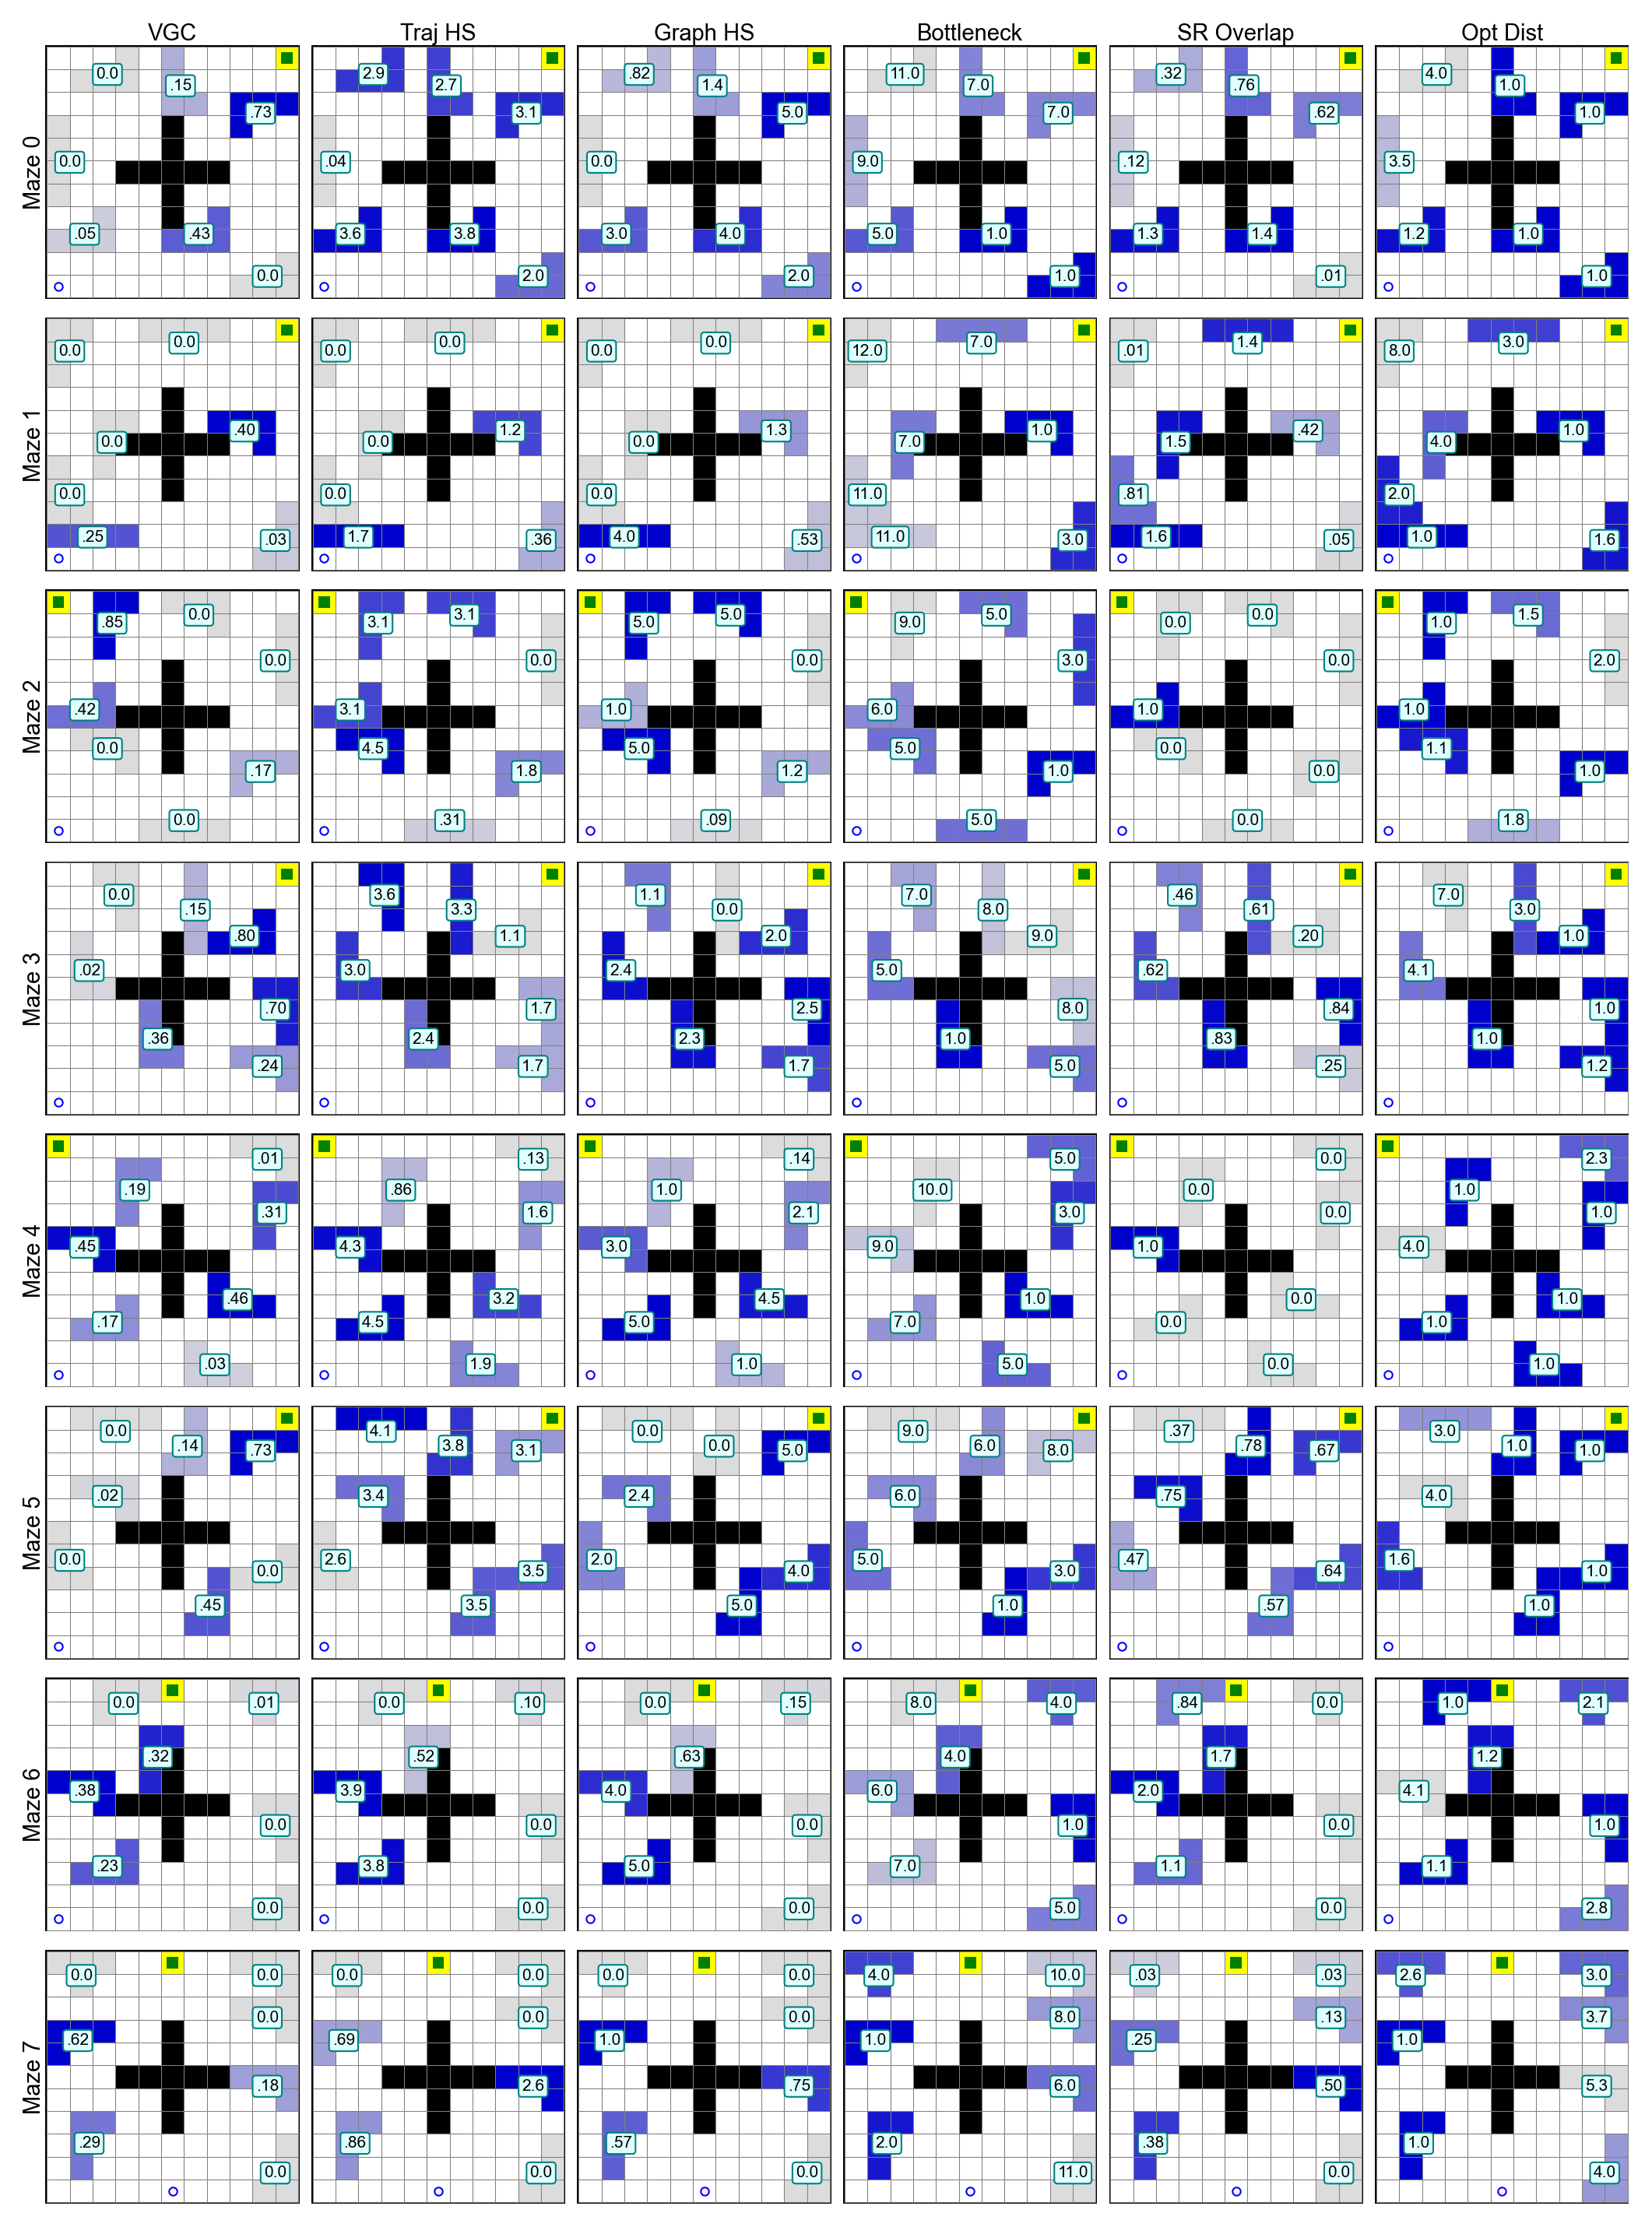

In [5]:
grid0_7_fig = create_grid_measure_plot(
    mazes_to_plot=[(g, m) for g, m in mazes.items() if int(g.split('-')[1]) <= 7],
    measures=models,
    grid_measure_obstacle_vals=grid_model_obstacle_vals,
    shortened_names=short_predictor_names,
    get_value_range=get_model_value_range
)
grid0_7_fig.savefig("results/grid_0_7_models.eps")

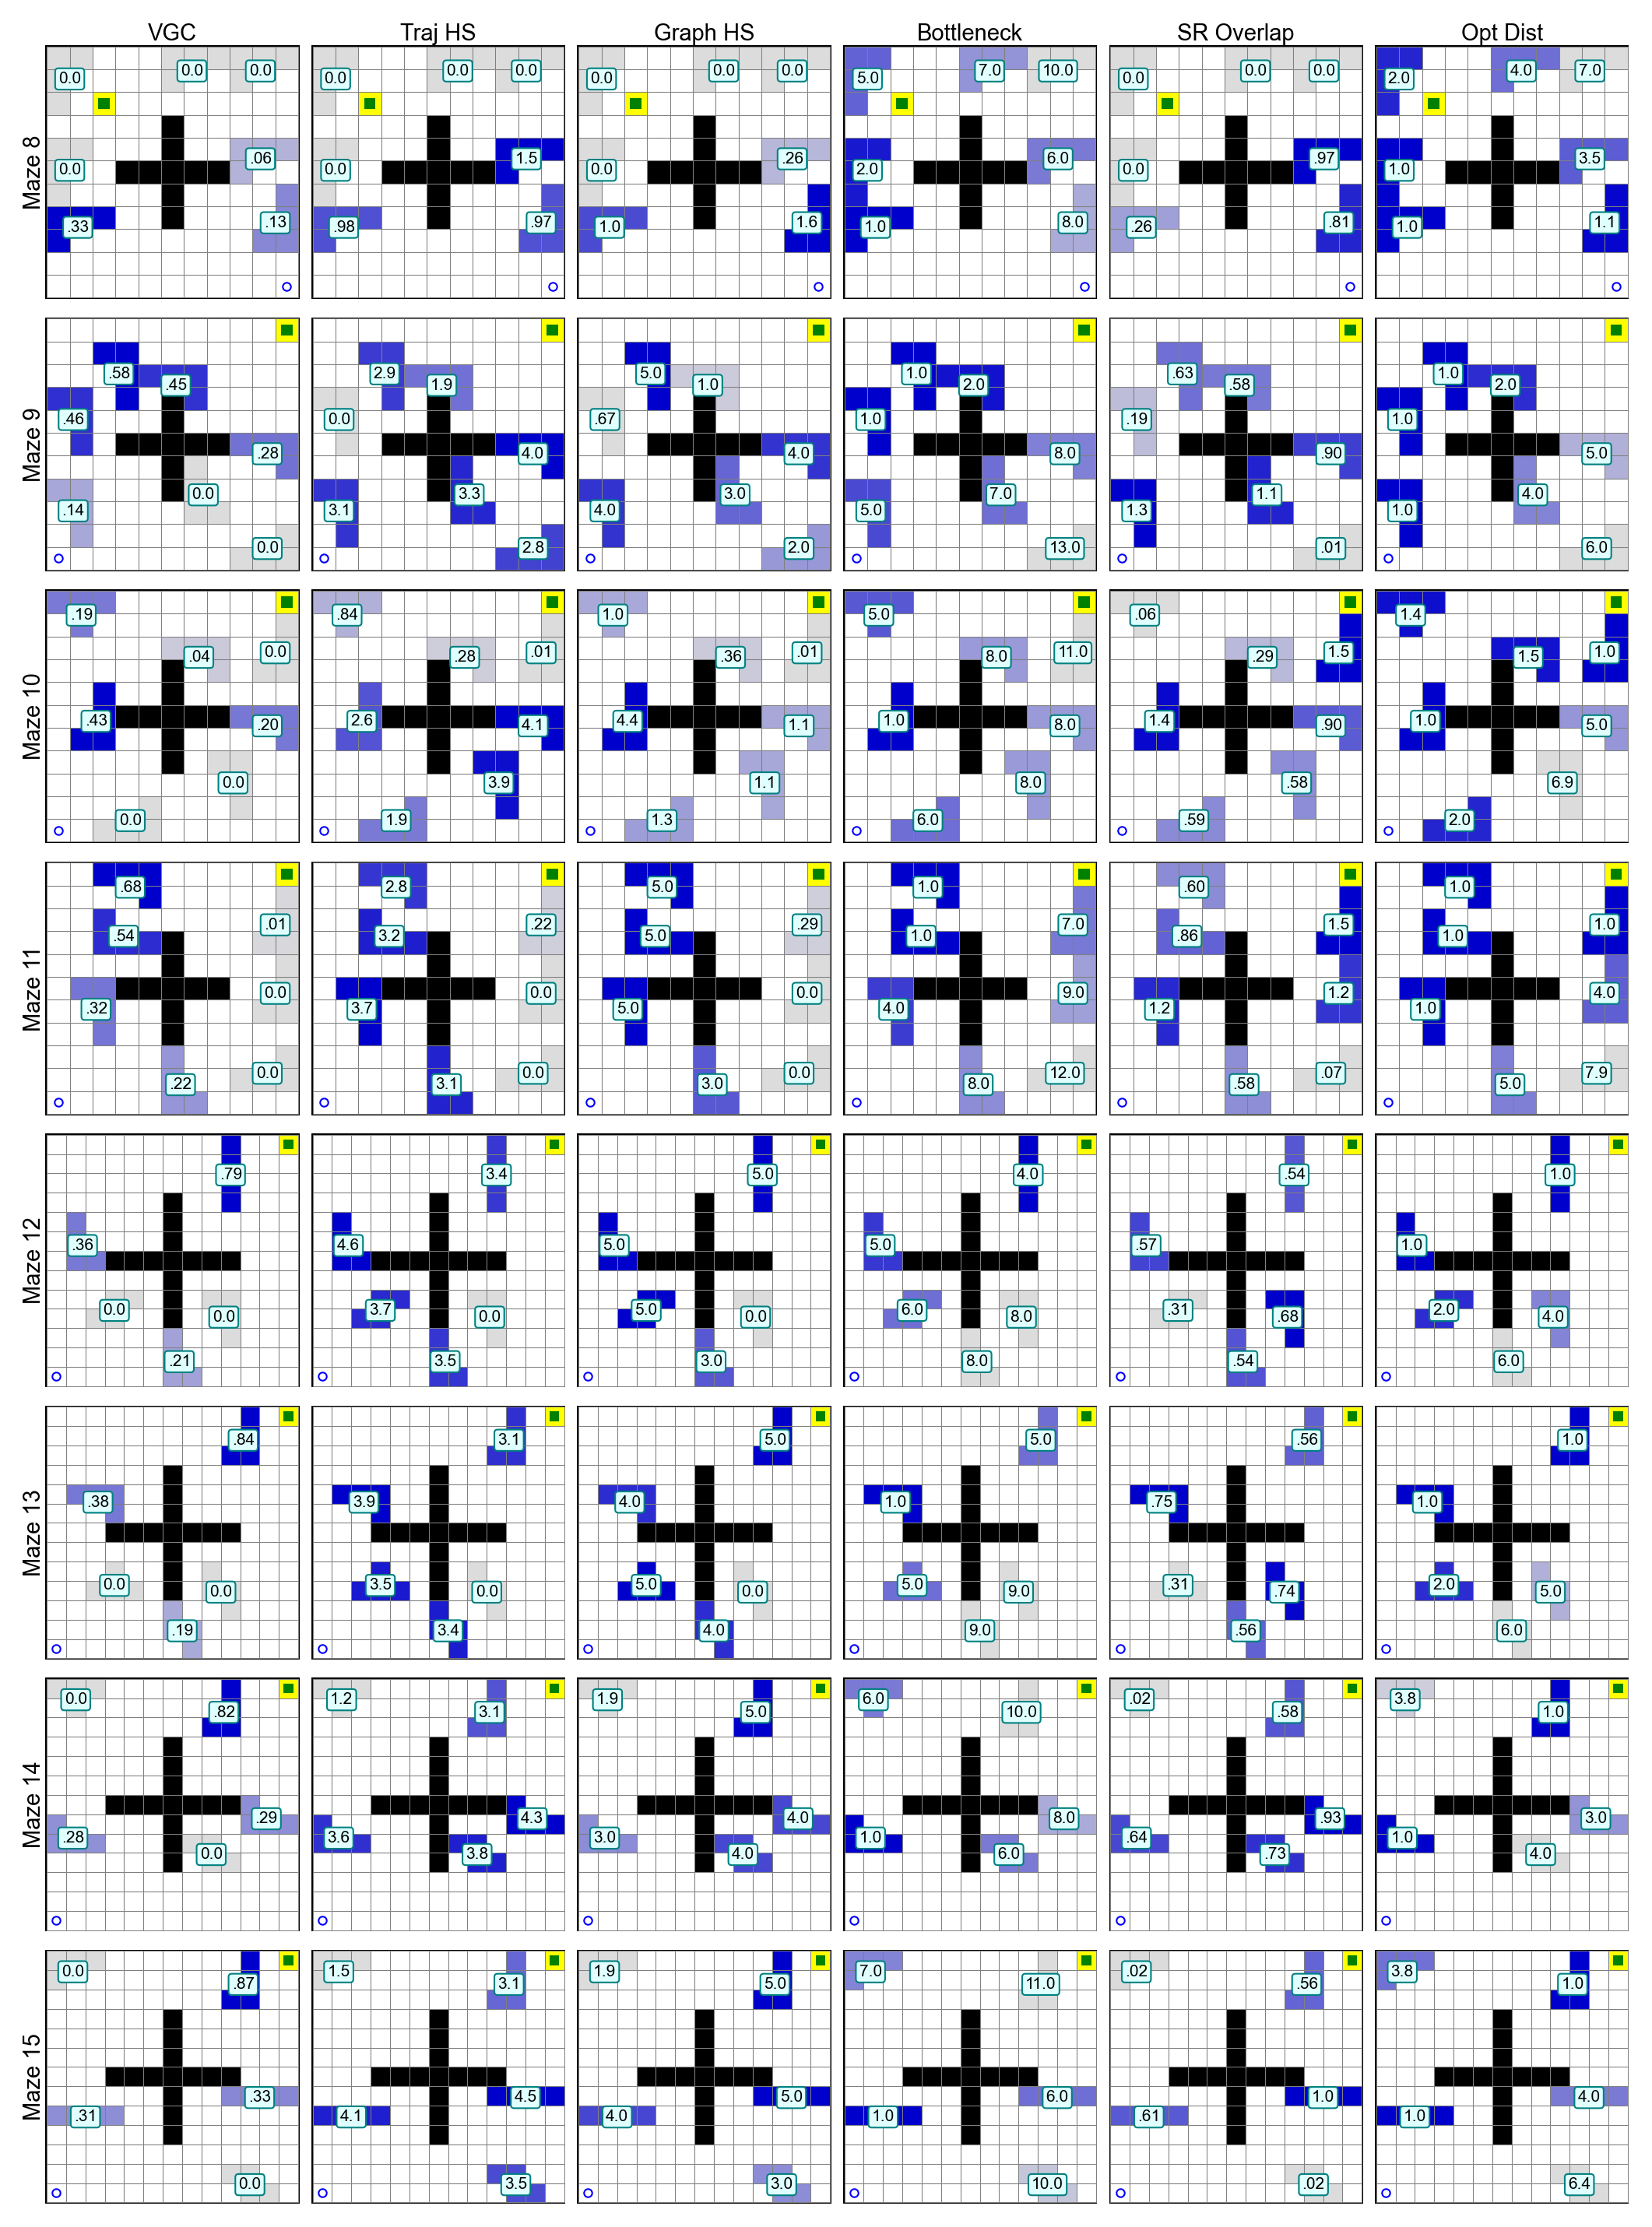

In [6]:
grid8_15_fig = create_grid_measure_plot(
    mazes_to_plot=[(g, m) for g, m in mazes.items() if int(g.split('-')[1]) > 7],
    measures=models,
    grid_measure_obstacle_vals=grid_model_obstacle_vals,
    shortened_names=short_predictor_names,
    get_value_range=get_model_value_range
)
grid8_15_fig.savefig("results/grid_8_15_models.eps")

## Create grid-measure plots for dependent variables from experiments

In [7]:
def get_grid_dv_obstacle_vals():
    exp1_at = get_exp1_at()
    exp2_at = get_exp2_at()
    exp3_at, exp3_mt = get_exp3_at__exp3_mt()
    exp4a_ht = get_exp4a_ht()
    exp4b_ht = get_exp4b_ht()
    mean_resp_0_11 = [
        (exp1_at.groupby(['grid', 'obstacle'])['attention_N'].mean(), "exp1_at"),
        (exp2_at.groupby(['grid', 'obstacle'])['attention_N'].mean(), "exp2_at"),
        (exp4a_ht.groupby(['grid', 'obstacle'])['hovered'].mean(), "exp4a_hov"),
        (exp4a_ht.groupby(['grid', 'obstacle'])['log_hoverduration'].mean(), "exp4a_dur"),
    ]
    mean_resp_0_11 = pd.concat(
        objs=[m for m, k in mean_resp_0_11],
        axis=1,
        keys=[k for m, k in mean_resp_0_11]
    ).reset_index()
    mean_resp_12_15 = [
        (exp3_at.groupby(['grid', 'obstacle'])['attention_N'].mean(), "exp3_at"),
        (exp3_mt.groupby(['grid', 'obstacle'])['correct'].mean(), "exp3_correct"),
        (exp3_mt.groupby(['grid', 'obstacle'])['conf_N'].mean(), "exp3_conf"),
        (exp4b_ht.groupby(['grid', 'obstacle'])['hovered'].mean(), "exp4b_hov"),
        (exp4b_ht.groupby(['grid', 'obstacle'])['log_hoverduration'].mean(), "exp4b_dur"),
    ]
    mean_resp_12_15 = pd.concat(
        objs=[m for m, k in mean_resp_12_15],
        axis=1,
        keys=[k for m, k in mean_resp_12_15]
    ).reset_index()
    grid_dv_obstacle_vals = {}
    for grid in mean_resp_0_11.grid.unique():
        grid_dv_obstacle_vals[grid] = {}
        for dv in ['exp1_at', 'exp2_at', 'exp4a_hov', 'exp4a_dur']:
            obstacle_values = dict(zip(
                mean_resp_0_11[mean_resp_0_11['grid'] == grid]['obstacle'].apply(lambda o: o.split('-')[1]),
                mean_resp_0_11[mean_resp_0_11['grid'] == grid][dv]
            ))
            grid_dv_obstacle_vals[grid][dv] = obstacle_values

    for grid in mean_resp_12_15.grid.unique():
        grid_dv_obstacle_vals[grid] = {}
        for dv in ['exp3_at', 'exp3_correct', 'exp3_conf', 'exp4b_hov', 'exp4b_dur']:
            obstacle_values = dict(zip(
                mean_resp_12_15[mean_resp_12_15['grid'] == grid]['obstacle'].apply(lambda o: o.split('-')[1]),
                mean_resp_12_15[mean_resp_12_15['grid'] == grid][dv]
            ))
            grid_dv_obstacle_vals[grid][dv] = obstacle_values
    return grid_dv_obstacle_vals

dv_names = {
    'exp1_at': "Initial Exp\nAwareness",
    'exp2_at': "Up-front planning\nAwareness",
    'exp3_correct': "Critical Mazes Exp\nAccuracy",
    'exp3_conf': "Critical Mazes Exp\nConfidence",
    'exp3_at': "Critical Mazes Exp\nAwareness",
    'exp4a_hov': "Process-tracing\nHovering",
    'exp4a_dur': "Process-tracing\nDuration",
    'exp4b_hov': "Process-tracing\nHovering",
    'exp4b_dur': "Process-tracing\nDuration",
}

In [8]:
grid_dv_obstacle_vals = get_grid_dv_obstacle_vals()

def get_dv_value_range(dv_name, obstacle_values):
    if "_at" in dv_name:
        return (.15, .85)
    if "_hov" in dv_name:
        return (0, 1)
    if "_dur" in dv_name:
        return (min(obstacle_values.values()), max(obstacle_values.values()))
    if "_correct" in dv_name:
        return (.5, 1)
    if "_conf" in dv_name:
        return (0, 1)
    raise


Loading Experiment 1 Attention Trials


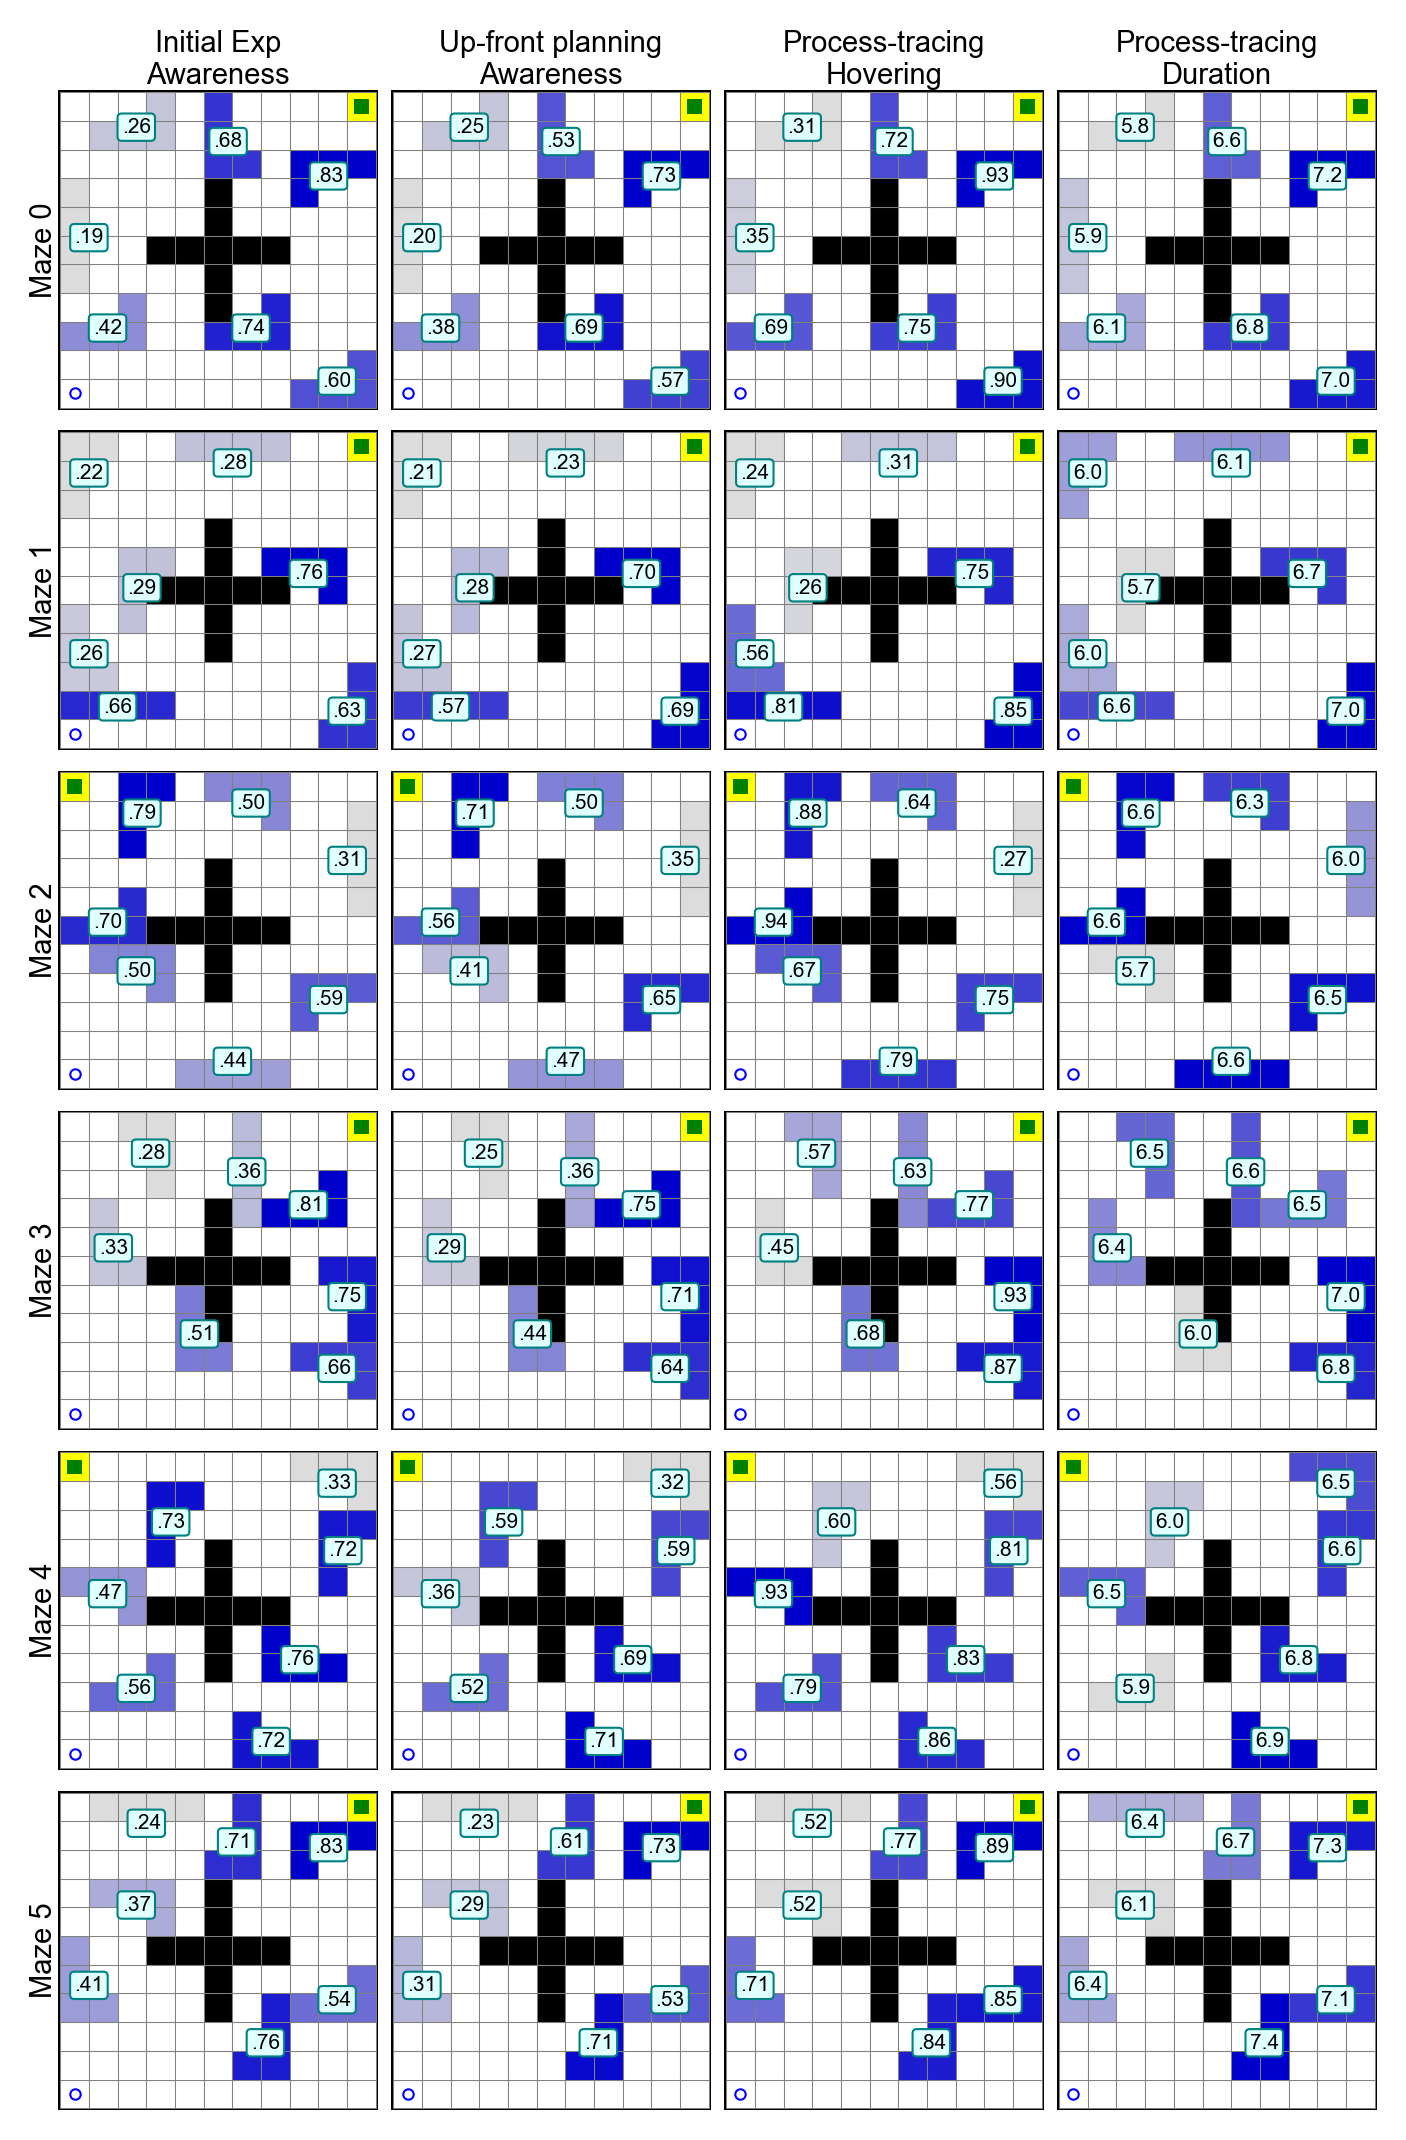

In [9]:
grid_0_5_exp_fig = create_grid_measure_plot(
    mazes_to_plot=[(g, m) for g, m in mazes.items() if int(g.split('-')[1]) <= 5],
    measures=['exp1_at', 'exp2_at', 'exp4a_hov', 'exp4a_dur'],
    grid_measure_obstacle_vals=grid_dv_obstacle_vals,
    shortened_names=dv_names,
    fig_width_mm=182*(4/6),
    fig_height_mm=245*(6/8),
    # get_value_range=get_dv_value_range
)
grid_0_5_exp_fig.savefig("results/grid_0_5_dvs.eps")

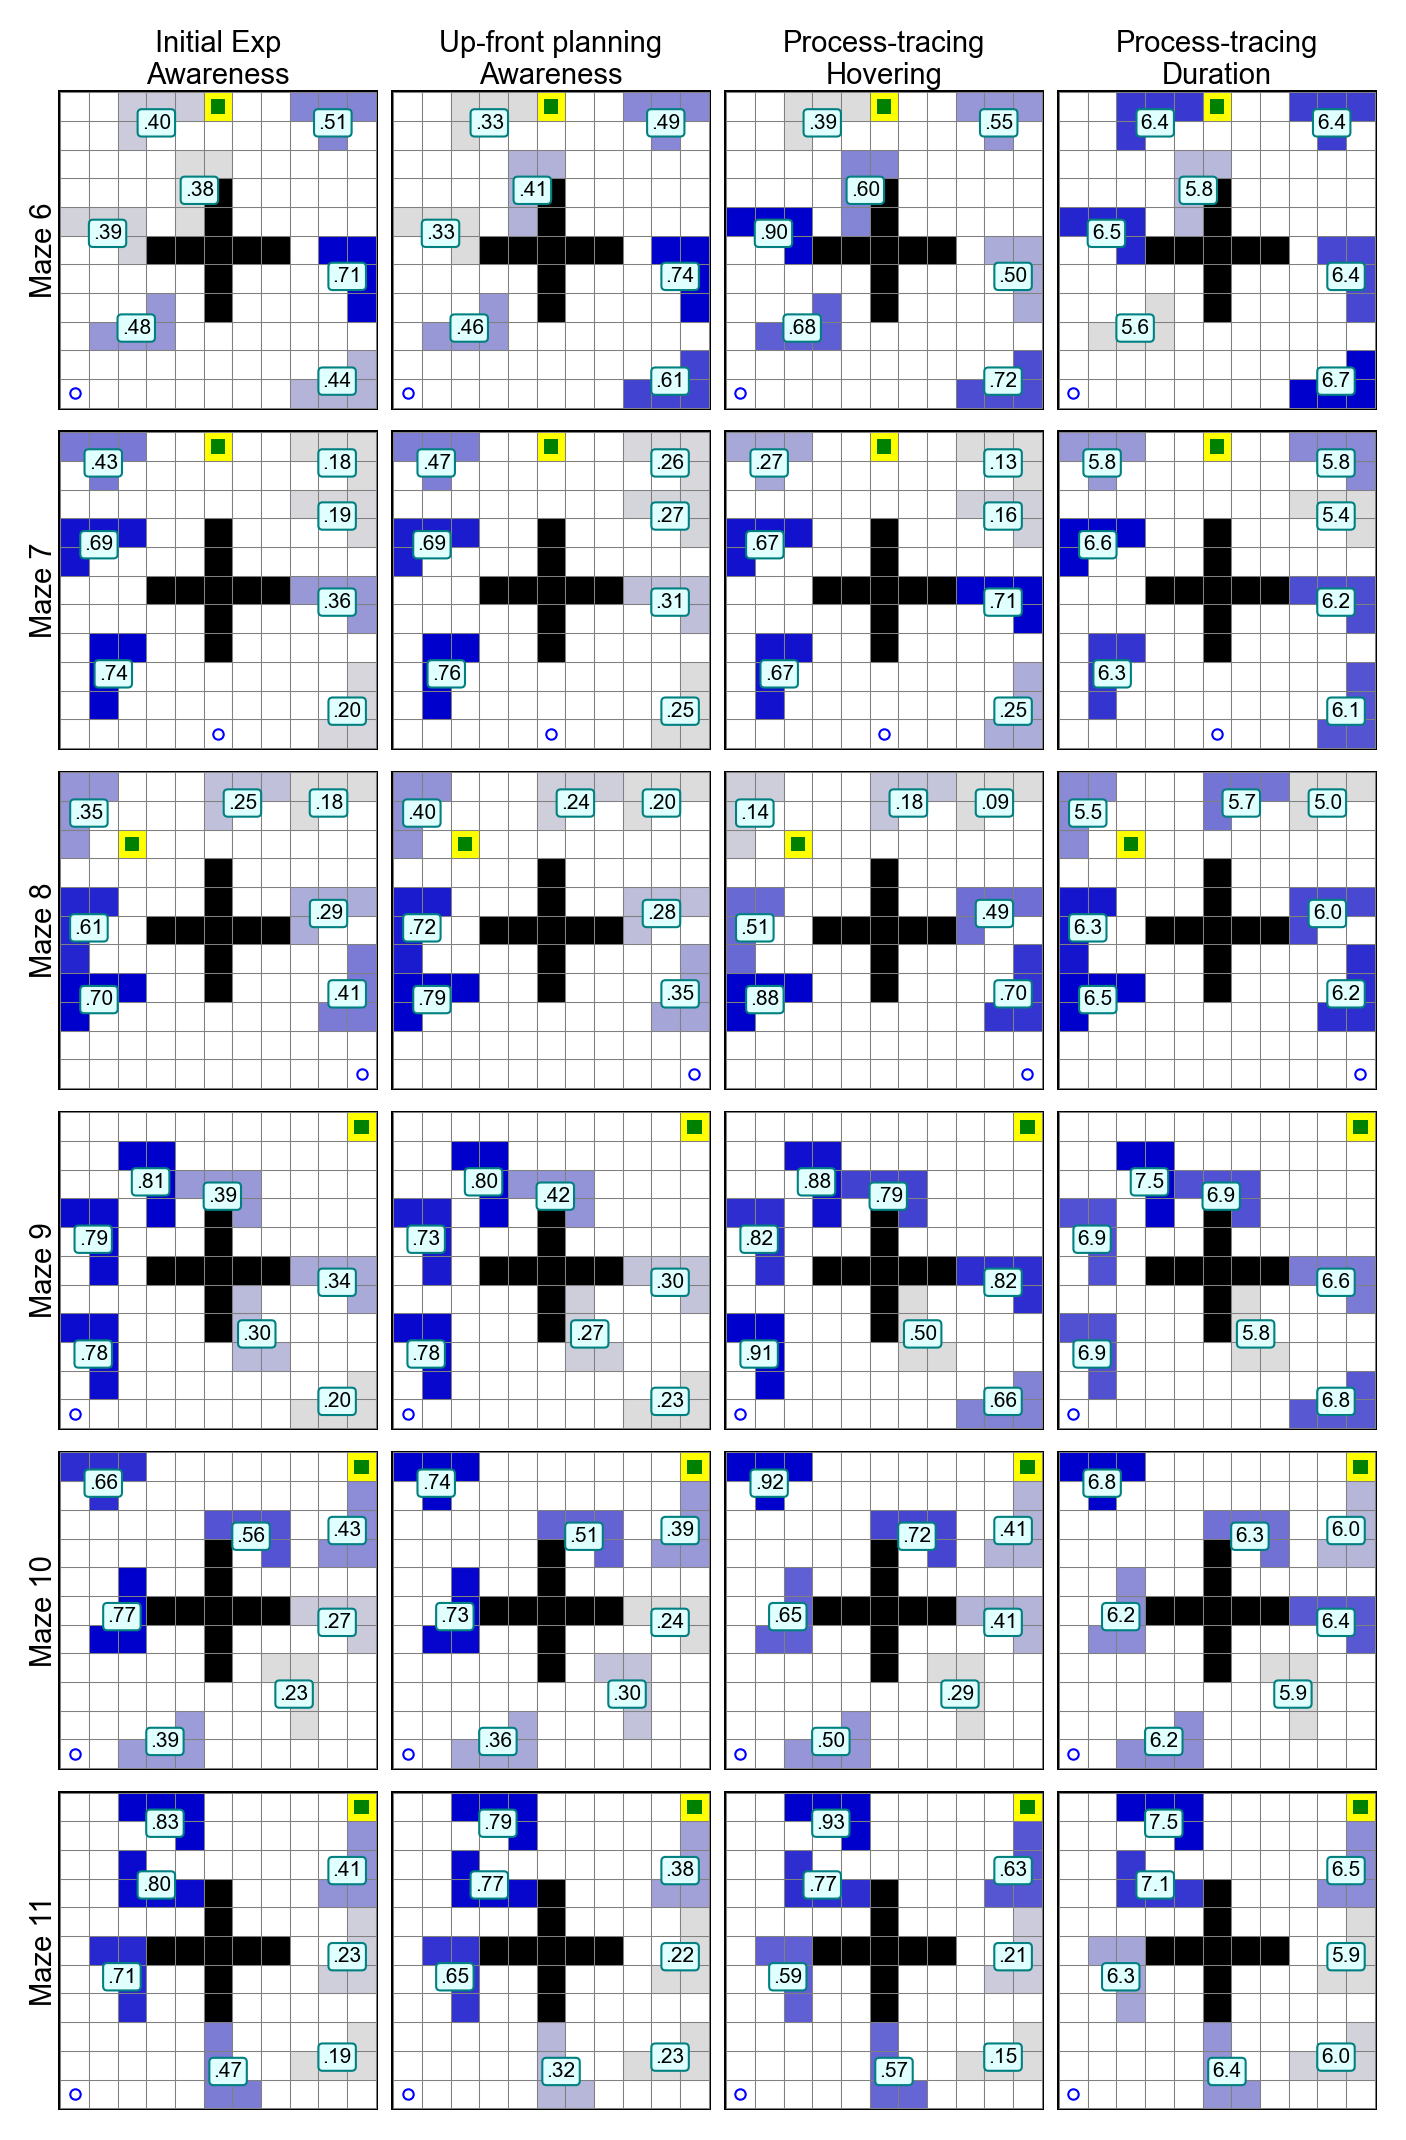

In [10]:
grid_6_11_exp_fig = create_grid_measure_plot(
    mazes_to_plot=[(g, m) for g, m in mazes.items() if 6 <= int(g.split('-')[1]) <= 11],
    measures=['exp1_at', 'exp2_at', 'exp4a_hov', 'exp4a_dur'],
    grid_measure_obstacle_vals=grid_dv_obstacle_vals,
    shortened_names=dv_names,
    fig_width_mm=182*(4/6),
    fig_height_mm=245*(6/8),
    # get_value_range=get_dv_value_range
)
grid_6_11_exp_fig.savefig("results/grid_6_11_dvs.eps")

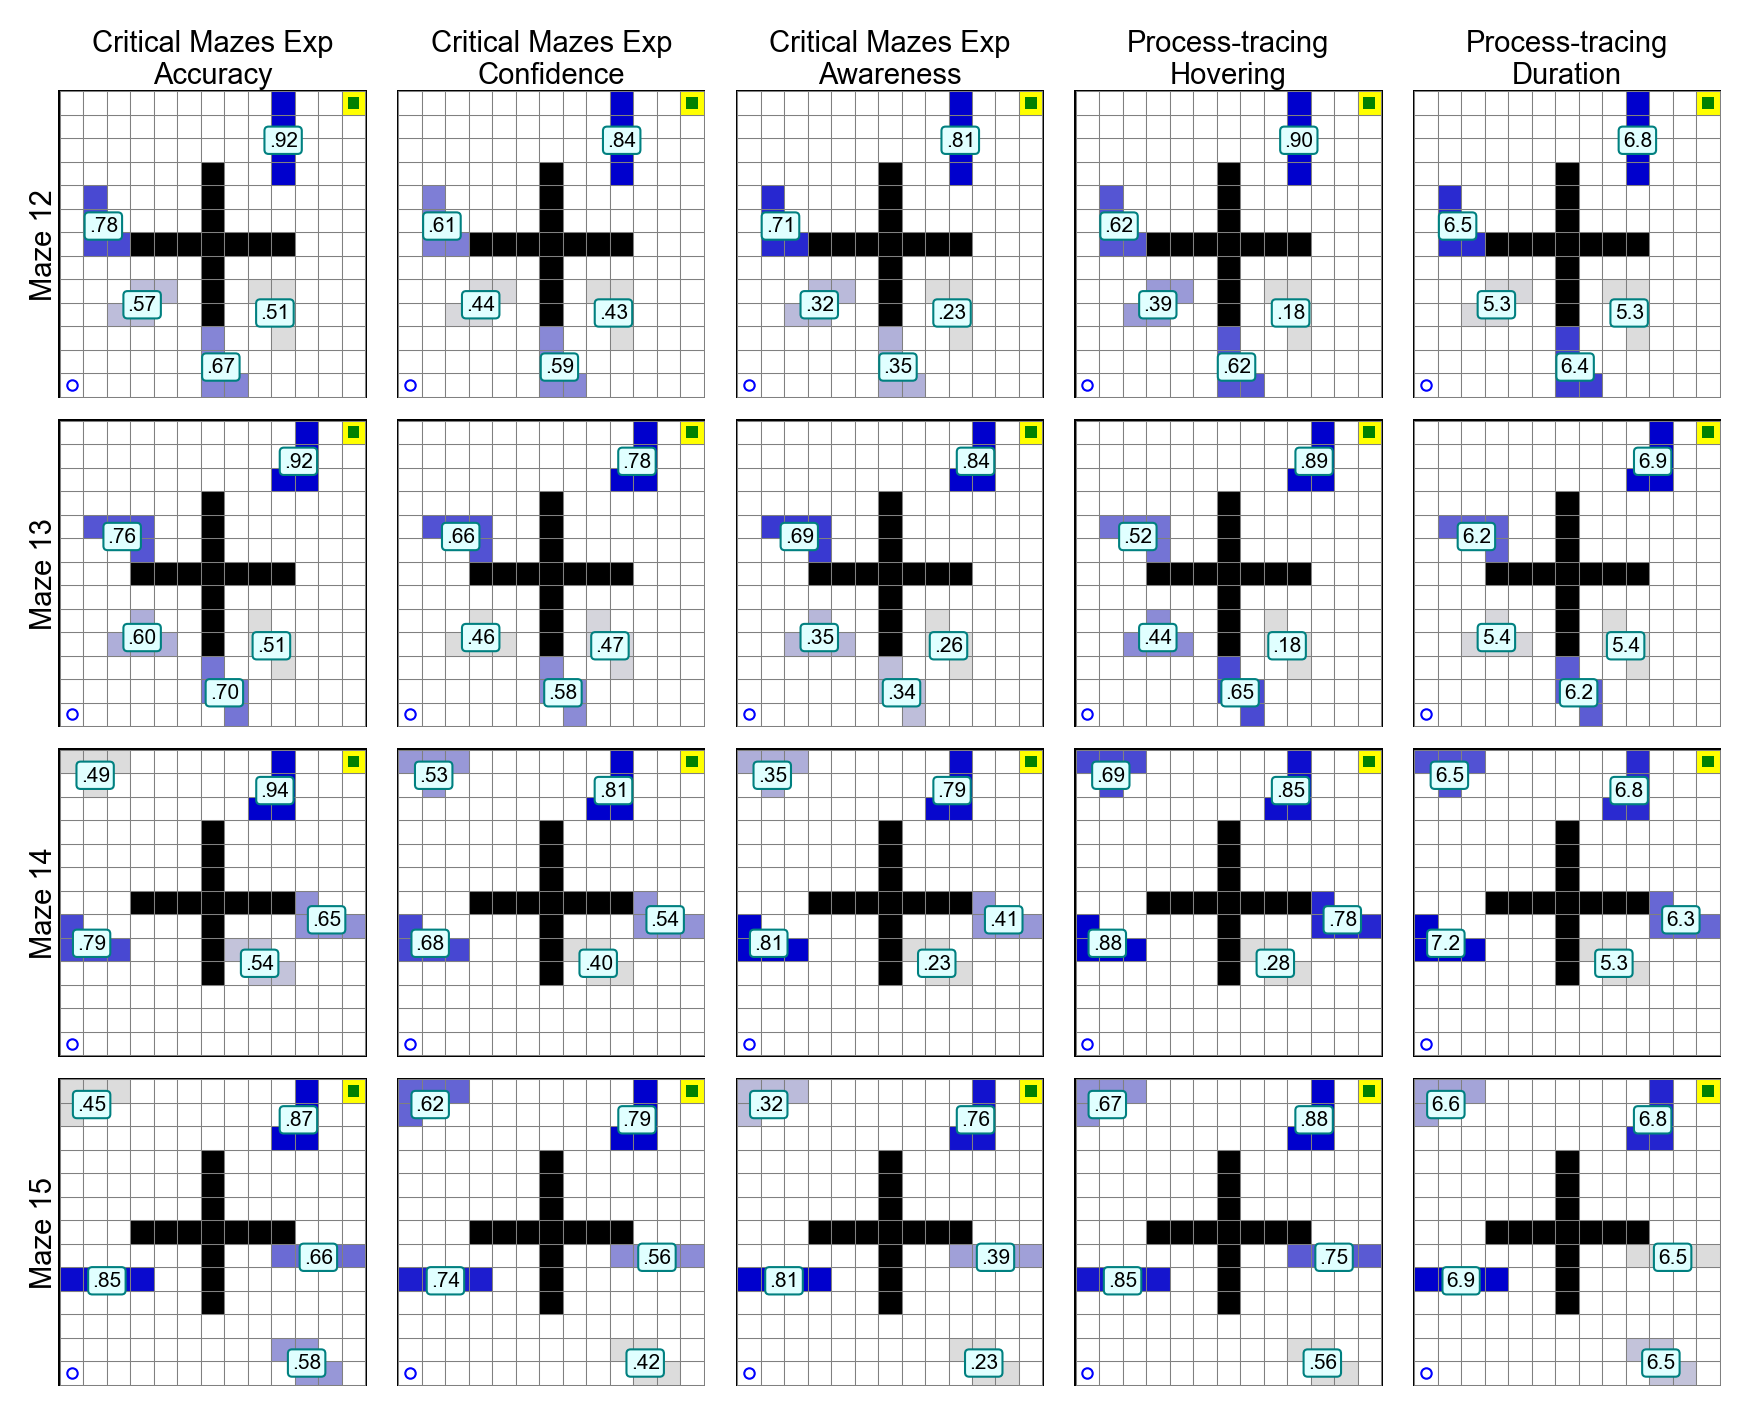

In [11]:
grid_12_15_exp_fig = create_grid_measure_plot(
    mazes_to_plot=[(g, m) for g, m in mazes.items() if int(g.split('-')[1]) > 11],
    measures=['exp3_correct', 'exp3_conf', 'exp3_at', 'exp4b_hov', 'exp4b_dur'],
    grid_measure_obstacle_vals=grid_dv_obstacle_vals,
    shortened_names=dv_names,
    fig_width_mm=182*(5/6),
    fig_height_mm=245*(4/8),
    # get_value_range=get_dv_value_range
)
grid_12_15_exp_fig.savefig("results/grid_12_15_dvs.eps")